# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

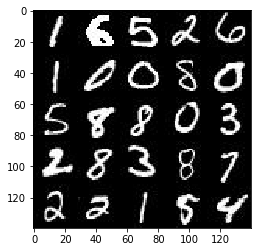

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

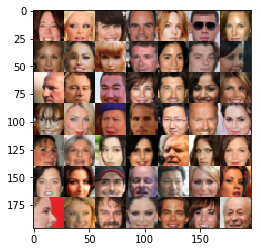

In [3]:
show_n_images = 50

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    t_real_imgs = tf.placeholder( tf.float32, shape=[ None, image_width, image_height, image_channels ], name='real_images' )
    t_z_data    = tf.placeholder( tf.float32, shape=[ None, z_dim ], name='z_input')
    learn_rate  = tf.placeholder( tf.float32, name='learning_rate' )

    return (t_real_imgs, t_z_data, learn_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # Notes:  
    # Build a convolutional neural network
    # 1 fully connected layer at end
    # batch_norm between the layers, except for the first to second
    # no max pool layers
    # downsample is done with stride in conv layers
    # final layer is flattened connected to single sigmoid unit
    # leaky relu activations
    
    #num_units = 128
    alpha     = 0.2
    
    # Leveraging code snippets from Intro_to_GANs notebook in the deep-learning repo under gan_mnist folder
    # as well as the DCGAN notebook from the dcgan-svhn folder
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # Input images:  28 x 28 x 3, with pixel values in range -0.5 to 0.5
        # Adopt general policy of increasing depth by 2 with each layer,
        # and downsample by a factor of 2
        img1  = tf.layers.conv2d( images, 56, 5, strides=2, padding='same')
        relu1 = tf.maximum( alpha * img1, img1 )
        # 14 x 14 x 56 out
        
        img2 = tf.layers.conv2d( relu1, 112, 5, strides=2, padding='same')
        b_norm2 = tf.layers.batch_normalization( img2, training=True )
        relu2 = tf.maximum( alpha * b_norm2, b_norm2)
        # 7 x 7 x 112 out
        
        # at this point, the image size is no longer a factor of 2. 
        # could try different strides or padding.
        # just going to see how this model works as is first, then
        # consider making network deeper if results are poor.
        
        # Flatten
        flat_layer = tf.reshape( relu2, (-1, 7*7*112))
      
        logits = tf.layers.dense( flat_layer, 1 )
        ouput = tf.sigmoid( logits )

    return (ouput, logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # Leveraging code snippets from the DCGAN notebook in the dcgan-svhn folder of deep-learning repo
    # Start out with a deep and narrow network, that eventually gets shallower and flatter until reaching
    # size of 28 x 28 x 3
    my_reuse = not is_train
    with tf.variable_scope('generator', reuse=my_reuse):
        g_alpha = 0.2
        
        x1 = tf.layers.dense( z, 7 * 7 * 512 )
                
        x1 = tf.reshape( x1, (-1, 7, 7, 512 ))
        x1 = tf.layers.batch_normalization( x1, training = is_train)
        x1 = tf.maximum( g_alpha * x1, x1 )   # leaky ReLU
        # output size:  7 x 7 x 512
        
        x2 = tf.layers.conv2d_transpose( x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization( x2, training=is_train)
        x2 = tf.maximum( g_alpha * x2, x2 )   # leaky ReLU
        # 14 x 14 x 256
        
        # output layer
        logits = tf.layers.conv2d_transpose( x2, out_channel_dim, 5, strides=2, padding='same')
        # 28 x 28 x 3
        
        gen_out = tf.tanh( logits )
        
        return gen_out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    gen_model = generator( input_z, out_channel_dim, is_train=True )
    
    # take real image input
    dsc_model_real, dsc_logits_real = discriminator(input_real, reuse=False)
    # take generator input
    dsc_model_fake, dsc_logits_fake = discriminator(gen_model, reuse=True)
    
    # Calculate loss
    dsc_loss_real = tf.reduce_mean( 
                    tf.nn.sigmoid_cross_entropy_with_logits( logits = dsc_logits_real, labels=tf.ones_like(dsc_model_real)))
    dsc_loss_fake = tf.reduce_mean( 
                    tf.nn.sigmoid_cross_entropy_with_logits( logits = dsc_logits_fake, labels=tf.zeros_like(dsc_model_fake)))
    
    gen_loss      = tf.reduce_mean(
                    tf.nn.sigmoid_cross_entropy_with_logits( logits = dsc_logits_fake, labels=tf.ones_like(dsc_model_fake)))
    
    dsc_loss = dsc_loss_real + dsc_loss_fake
    
    return (dsc_loss, gen_loss )


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    train_vars = tf.trainable_variables()
    dsc_vars = [ var for var in train_vars if var.name.startswith('discriminator')]
    gen_vars = [ var for var in train_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies( tf.get_collection( tf.GraphKeys.UPDATE_OPS)):
        dsc_train_op = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=dsc_vars)
        gen_train_op = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=gen_vars)
    
    return (dsc_train_op, gen_train_op)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    #saver = tf.train.Saver()
    #tf.reset_default_graph()  per forum input, remove due to potential undefined behavior
    
    # Like the __init__ section of DCGAN.ipynb notebook
    # model_inputs(image_width, image_height, image_channels, z_dim)
#    print( "image_width    = ", data_shape[1] )
#    print( "image_height   = ", data_shape[2] )
#    print( "batch_size     = ", batch_size )
#    print( "z_dim          = ", z_dim )
    
    # model_inputs(image_width, image_height, image_channels, z_dim)
    real_imgs, z_data, learn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)

    # model_loss(input_real, input_z, out_channel_dim)
    dsc_loss, gen_loss = model_loss(real_imgs, z_data, data_shape[3])
    
    # model_opt(d_loss, g_loss, learning_rate, beta1)
    dsc_train_op, gen_train_op = model_opt(dsc_loss, gen_loss, learning_rate, beta1)

    samples, losses = [], []
    
    print_cycle = 10
    show_cycle  = 100
    steps       = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                # Sample random noise for generator
                batch_z = np.random.uniform( -0.5, 0.5, size=(batch_size, z_dim ) )
                
                # Run optimizers
                # ISSUES HERE --------------------------------------------------------------
                _ = sess.run( dsc_train_op, feed_dict={ real_imgs: batch_images, 
                                                        z_data: batch_z })
                # ISSUES HERE --------------------------------------------------------------
                
                _ = sess.run( gen_train_op, feed_dict={ z_data: batch_z,
                                                        real_imgs: batch_images } )
                
                if steps % print_cycle == 0:
                    train_loss_dsc = dsc_loss.eval({ z_data: batch_z, real_imgs: batch_images }) 
                    train_loss_gen = gen_loss.eval({ z_data: batch_z })
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_dsc),
                          "Generator Loss: {:.4f}".format(train_loss_gen))
                    
                    # Save losses to view after training
                    losses.append((train_loss_dsc, train_loss_gen))                    
                
                if steps % show_cycle == 0:
                    # show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode)
                    show_generator_output(sess, 25, z_data, data_shape[3], data_image_mode)
        
        #saver.save(sess, './checkpoints/generator.ckpt')
    
    return losses, samples    

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 3.4017... Generator Loss: 0.0591
Epoch 1/2... Discriminator Loss: 1.5269... Generator Loss: 0.5918
Epoch 1/2... Discriminator Loss: 2.5420... Generator Loss: 0.2802
Epoch 1/2... Discriminator Loss: 2.3403... Generator Loss: 0.4408
Epoch 1/2... Discriminator Loss: 1.9487... Generator Loss: 0.5535
Epoch 1/2... Discriminator Loss: 1.6391... Generator Loss: 0.6198
Epoch 1/2... Discriminator Loss: 1.8419... Generator Loss: 0.4938
Epoch 1/2... Discriminator Loss: 1.2309... Generator Loss: 0.8843
Epoch 1/2... Discriminator Loss: 1.6440... Generator Loss: 0.5914
Epoch 1/2... Discriminator Loss: 1.3399... Generator Loss: 0.7916


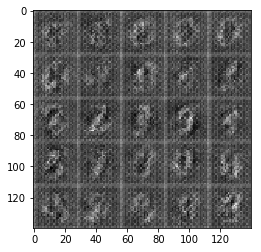

Epoch 1/2... Discriminator Loss: 1.2271... Generator Loss: 0.8531
Epoch 1/2... Discriminator Loss: 1.0759... Generator Loss: 0.9314
Epoch 1/2... Discriminator Loss: 1.1668... Generator Loss: 0.8026
Epoch 1/2... Discriminator Loss: 0.9751... Generator Loss: 0.8487
Epoch 1/2... Discriminator Loss: 1.0133... Generator Loss: 0.8549
Epoch 1/2... Discriminator Loss: 0.7400... Generator Loss: 1.1597
Epoch 1/2... Discriminator Loss: 0.8572... Generator Loss: 1.1475
Epoch 1/2... Discriminator Loss: 1.1389... Generator Loss: 0.8442
Epoch 1/2... Discriminator Loss: 1.0247... Generator Loss: 0.8434
Epoch 1/2... Discriminator Loss: 1.1178... Generator Loss: 1.7764


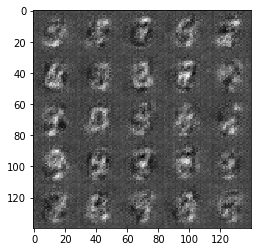

Epoch 1/2... Discriminator Loss: 0.8701... Generator Loss: 1.6525
Epoch 1/2... Discriminator Loss: 1.2849... Generator Loss: 0.4755
Epoch 1/2... Discriminator Loss: 1.0472... Generator Loss: 0.7418
Epoch 1/2... Discriminator Loss: 0.8640... Generator Loss: 1.5000
Epoch 1/2... Discriminator Loss: 0.9845... Generator Loss: 0.7430
Epoch 1/2... Discriminator Loss: 0.9750... Generator Loss: 0.7485
Epoch 1/2... Discriminator Loss: 1.0355... Generator Loss: 0.6752
Epoch 1/2... Discriminator Loss: 0.9227... Generator Loss: 0.8248
Epoch 1/2... Discriminator Loss: 0.8614... Generator Loss: 0.9683
Epoch 1/2... Discriminator Loss: 0.7037... Generator Loss: 1.2938


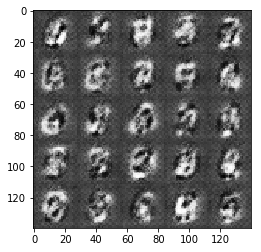

Epoch 1/2... Discriminator Loss: 0.7321... Generator Loss: 1.2137
Epoch 1/2... Discriminator Loss: 0.8894... Generator Loss: 0.8753
Epoch 1/2... Discriminator Loss: 0.7865... Generator Loss: 1.6283
Epoch 1/2... Discriminator Loss: 0.7852... Generator Loss: 0.9837
Epoch 1/2... Discriminator Loss: 0.7108... Generator Loss: 1.3469
Epoch 1/2... Discriminator Loss: 0.7023... Generator Loss: 1.3720
Epoch 1/2... Discriminator Loss: 0.9211... Generator Loss: 0.7294
Epoch 1/2... Discriminator Loss: 0.9711... Generator Loss: 0.6598
Epoch 1/2... Discriminator Loss: 0.7211... Generator Loss: 0.9938
Epoch 1/2... Discriminator Loss: 0.6137... Generator Loss: 1.2502


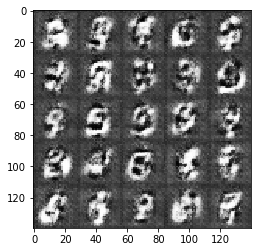

Epoch 1/2... Discriminator Loss: 0.6380... Generator Loss: 1.6170
Epoch 1/2... Discriminator Loss: 0.7240... Generator Loss: 2.5754
Epoch 1/2... Discriminator Loss: 0.5263... Generator Loss: 1.8483
Epoch 1/2... Discriminator Loss: 0.8566... Generator Loss: 3.1214
Epoch 1/2... Discriminator Loss: 0.6524... Generator Loss: 2.2071
Epoch 1/2... Discriminator Loss: 0.7078... Generator Loss: 1.0463
Epoch 2/2... Discriminator Loss: 0.4953... Generator Loss: 2.1790
Epoch 2/2... Discriminator Loss: 0.6203... Generator Loss: 2.5176
Epoch 2/2... Discriminator Loss: 0.7553... Generator Loss: 0.8469
Epoch 2/2... Discriminator Loss: 0.4267... Generator Loss: 2.1331


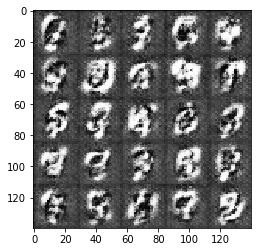

Epoch 2/2... Discriminator Loss: 0.6994... Generator Loss: 3.0125
Epoch 2/2... Discriminator Loss: 0.4949... Generator Loss: 1.4864
Epoch 2/2... Discriminator Loss: 0.4574... Generator Loss: 2.4782
Epoch 2/2... Discriminator Loss: 0.5647... Generator Loss: 2.9079
Epoch 2/2... Discriminator Loss: 0.5085... Generator Loss: 1.4395
Epoch 2/2... Discriminator Loss: 0.3911... Generator Loss: 2.5307
Epoch 2/2... Discriminator Loss: 0.5165... Generator Loss: 2.3072
Epoch 2/2... Discriminator Loss: 0.3528... Generator Loss: 2.9879
Epoch 2/2... Discriminator Loss: 0.4464... Generator Loss: 2.9034
Epoch 2/2... Discriminator Loss: 0.3052... Generator Loss: 2.5594


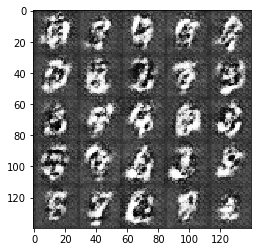

Epoch 2/2... Discriminator Loss: 0.3928... Generator Loss: 2.4634
Epoch 2/2... Discriminator Loss: 0.3884... Generator Loss: 2.7747
Epoch 2/2... Discriminator Loss: 0.3458... Generator Loss: 2.1489
Epoch 2/2... Discriminator Loss: 0.4115... Generator Loss: 3.2743
Epoch 2/2... Discriminator Loss: 0.4012... Generator Loss: 2.4984
Epoch 2/2... Discriminator Loss: 0.3112... Generator Loss: 2.8977
Epoch 2/2... Discriminator Loss: 0.3762... Generator Loss: 2.4457
Epoch 2/2... Discriminator Loss: 0.3324... Generator Loss: 2.4319
Epoch 2/2... Discriminator Loss: 0.7147... Generator Loss: 2.0969
Epoch 2/2... Discriminator Loss: 0.2994... Generator Loss: 2.2744


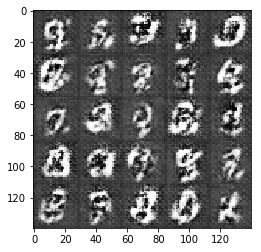

Epoch 2/2... Discriminator Loss: 0.6219... Generator Loss: 3.0638
Epoch 2/2... Discriminator Loss: 0.3066... Generator Loss: 2.0436
Epoch 2/2... Discriminator Loss: 0.5041... Generator Loss: 2.5008
Epoch 2/2... Discriminator Loss: 0.3338... Generator Loss: 3.2310
Epoch 2/2... Discriminator Loss: 0.4430... Generator Loss: 3.2123
Epoch 2/2... Discriminator Loss: 0.2530... Generator Loss: 2.6209
Epoch 2/2... Discriminator Loss: 0.5556... Generator Loss: 2.9978
Epoch 2/2... Discriminator Loss: 0.3065... Generator Loss: 3.1706
Epoch 2/2... Discriminator Loss: 0.3828... Generator Loss: 2.3227
Epoch 2/2... Discriminator Loss: 0.2752... Generator Loss: 1.9790


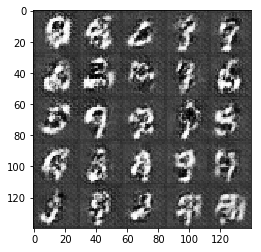

Epoch 2/2... Discriminator Loss: 0.3401... Generator Loss: 2.7525
Epoch 2/2... Discriminator Loss: 0.2352... Generator Loss: 2.9832
Epoch 2/2... Discriminator Loss: 0.5222... Generator Loss: 3.0384
Epoch 2/2... Discriminator Loss: 0.2538... Generator Loss: 3.2677
Epoch 2/2... Discriminator Loss: 0.4731... Generator Loss: 3.0481
Epoch 2/2... Discriminator Loss: 0.2929... Generator Loss: 2.7042
Epoch 2/2... Discriminator Loss: 0.6557... Generator Loss: 2.9697
Epoch 2/2... Discriminator Loss: 0.4441... Generator Loss: 1.4588
Epoch 2/2... Discriminator Loss: 0.4442... Generator Loss: 1.3915
Epoch 2/2... Discriminator Loss: 0.6406... Generator Loss: 1.0004


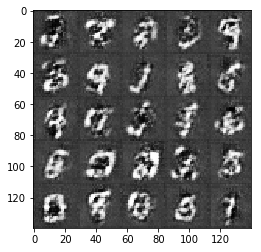

Epoch 2/2... Discriminator Loss: 0.6607... Generator Loss: 0.9095
Epoch 2/2... Discriminator Loss: 0.7724... Generator Loss: 0.8355
Epoch 2/2... Discriminator Loss: 0.4897... Generator Loss: 1.2047


In [12]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 5.4379... Generator Loss: 0.0083
Epoch 1/1... Discriminator Loss: 5.3728... Generator Loss: 0.0129
Epoch 1/1... Discriminator Loss: 3.6091... Generator Loss: 0.1115
Epoch 1/1... Discriminator Loss: 3.7626... Generator Loss: 0.1061
Epoch 1/1... Discriminator Loss: 2.9999... Generator Loss: 0.3738
Epoch 1/1... Discriminator Loss: 2.6059... Generator Loss: 0.4437
Epoch 1/1... Discriminator Loss: 2.1435... Generator Loss: 0.5241
Epoch 1/1... Discriminator Loss: 1.8342... Generator Loss: 0.4873
Epoch 1/1... Discriminator Loss: 1.2831... Generator Loss: 0.9705
Epoch 1/1... Discriminator Loss: 1.4024... Generator Loss: 0.6816


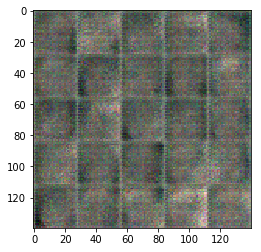

Epoch 1/1... Discriminator Loss: 1.0274... Generator Loss: 1.3796
Epoch 1/1... Discriminator Loss: 1.2188... Generator Loss: 0.6958
Epoch 1/1... Discriminator Loss: 1.1290... Generator Loss: 0.6128
Epoch 1/1... Discriminator Loss: 0.8342... Generator Loss: 0.8408
Epoch 1/1... Discriminator Loss: 0.5667... Generator Loss: 2.2721
Epoch 1/1... Discriminator Loss: 1.6960... Generator Loss: 0.2529
Epoch 1/1... Discriminator Loss: 0.6502... Generator Loss: 1.0837
Epoch 1/1... Discriminator Loss: 2.0599... Generator Loss: 0.1729
Epoch 1/1... Discriminator Loss: 0.2569... Generator Loss: 2.7769
Epoch 1/1... Discriminator Loss: 1.1523... Generator Loss: 0.9538


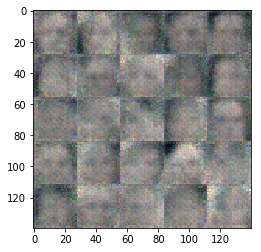

Epoch 1/1... Discriminator Loss: 0.2317... Generator Loss: 2.7098
Epoch 1/1... Discriminator Loss: 0.8581... Generator Loss: 0.8511
Epoch 1/1... Discriminator Loss: 1.7097... Generator Loss: 0.2622
Epoch 1/1... Discriminator Loss: 2.0268... Generator Loss: 0.3350
Epoch 1/1... Discriminator Loss: 0.7344... Generator Loss: 0.9706
Epoch 1/1... Discriminator Loss: 0.6841... Generator Loss: 1.2056
Epoch 1/1... Discriminator Loss: 0.4578... Generator Loss: 5.3289
Epoch 1/1... Discriminator Loss: 0.2064... Generator Loss: 5.4880
Epoch 1/1... Discriminator Loss: 0.8213... Generator Loss: 1.1114
Epoch 1/1... Discriminator Loss: 2.9470... Generator Loss: 0.0639


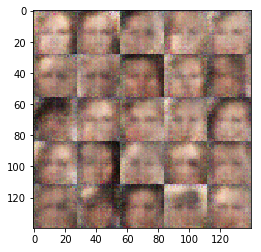

Epoch 1/1... Discriminator Loss: 0.3660... Generator Loss: 2.3158
Epoch 1/1... Discriminator Loss: 0.8771... Generator Loss: 1.8567
Epoch 1/1... Discriminator Loss: 1.9119... Generator Loss: 0.3890
Epoch 1/1... Discriminator Loss: 0.6620... Generator Loss: 6.1103
Epoch 1/1... Discriminator Loss: 1.0681... Generator Loss: 0.5365
Epoch 1/1... Discriminator Loss: 1.1700... Generator Loss: 0.8117
Epoch 1/1... Discriminator Loss: 0.6713... Generator Loss: 4.5898
Epoch 1/1... Discriminator Loss: 0.2294... Generator Loss: 7.2551
Epoch 1/1... Discriminator Loss: 0.2416... Generator Loss: 2.3191
Epoch 1/1... Discriminator Loss: 0.4489... Generator Loss: 6.6983


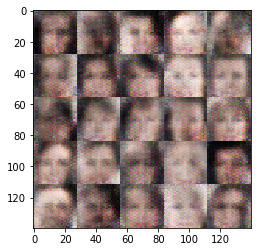

Epoch 1/1... Discriminator Loss: 1.7032... Generator Loss: 0.2633
Epoch 1/1... Discriminator Loss: 1.1500... Generator Loss: 1.2773
Epoch 1/1... Discriminator Loss: 0.5201... Generator Loss: 2.3555
Epoch 1/1... Discriminator Loss: 0.4258... Generator Loss: 5.8966
Epoch 1/1... Discriminator Loss: 1.4009... Generator Loss: 0.4659
Epoch 1/1... Discriminator Loss: 2.2233... Generator Loss: 0.1474
Epoch 1/1... Discriminator Loss: 1.0208... Generator Loss: 0.9344
Epoch 1/1... Discriminator Loss: 0.8975... Generator Loss: 0.9175
Epoch 1/1... Discriminator Loss: 1.3964... Generator Loss: 1.0165
Epoch 1/1... Discriminator Loss: 1.3955... Generator Loss: 0.4527


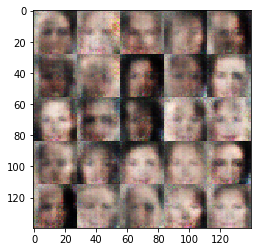

Epoch 1/1... Discriminator Loss: 0.9481... Generator Loss: 0.7981
Epoch 1/1... Discriminator Loss: 0.3544... Generator Loss: 5.0264
Epoch 1/1... Discriminator Loss: 0.9653... Generator Loss: 0.9476
Epoch 1/1... Discriminator Loss: 0.5729... Generator Loss: 2.6116
Epoch 1/1... Discriminator Loss: 0.4865... Generator Loss: 3.1775
Epoch 1/1... Discriminator Loss: 1.9700... Generator Loss: 0.1998
Epoch 1/1... Discriminator Loss: 0.6129... Generator Loss: 1.8843
Epoch 1/1... Discriminator Loss: 0.5430... Generator Loss: 4.6827
Epoch 1/1... Discriminator Loss: 1.0137... Generator Loss: 0.8118
Epoch 1/1... Discriminator Loss: 0.3814... Generator Loss: 3.6692


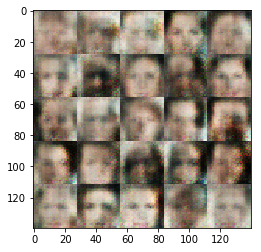

Epoch 1/1... Discriminator Loss: 1.1671... Generator Loss: 0.5520
Epoch 1/1... Discriminator Loss: 0.3694... Generator Loss: 3.4462
Epoch 1/1... Discriminator Loss: 1.2806... Generator Loss: 0.4693
Epoch 1/1... Discriminator Loss: 0.3772... Generator Loss: 5.8621
Epoch 1/1... Discriminator Loss: 0.6610... Generator Loss: 2.7087
Epoch 1/1... Discriminator Loss: 0.6455... Generator Loss: 1.4752
Epoch 1/1... Discriminator Loss: 1.1491... Generator Loss: 0.5105
Epoch 1/1... Discriminator Loss: 0.4777... Generator Loss: 4.1348
Epoch 1/1... Discriminator Loss: 0.4461... Generator Loss: 2.3265
Epoch 1/1... Discriminator Loss: 0.4348... Generator Loss: 2.4421


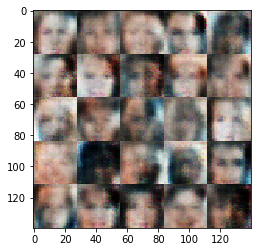

Epoch 1/1... Discriminator Loss: 0.6353... Generator Loss: 1.0784
Epoch 1/1... Discriminator Loss: 0.6049... Generator Loss: 1.3144
Epoch 1/1... Discriminator Loss: 0.2549... Generator Loss: 2.5202
Epoch 1/1... Discriminator Loss: 0.5296... Generator Loss: 2.8049
Epoch 1/1... Discriminator Loss: 0.5035... Generator Loss: 3.4647
Epoch 1/1... Discriminator Loss: 0.3378... Generator Loss: 3.9558
Epoch 1/1... Discriminator Loss: 0.3689... Generator Loss: 2.2054
Epoch 1/1... Discriminator Loss: 1.3867... Generator Loss: 0.4398
Epoch 1/1... Discriminator Loss: 0.4185... Generator Loss: 1.9258
Epoch 1/1... Discriminator Loss: 0.6237... Generator Loss: 3.7667


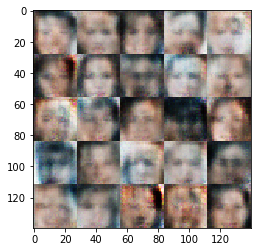

Epoch 1/1... Discriminator Loss: 0.6260... Generator Loss: 1.3410
Epoch 1/1... Discriminator Loss: 0.5450... Generator Loss: 5.7097
Epoch 1/1... Discriminator Loss: 0.7555... Generator Loss: 1.1395
Epoch 1/1... Discriminator Loss: 1.1607... Generator Loss: 0.6033
Epoch 1/1... Discriminator Loss: 0.8436... Generator Loss: 0.8847
Epoch 1/1... Discriminator Loss: 1.3086... Generator Loss: 2.9288
Epoch 1/1... Discriminator Loss: 0.2908... Generator Loss: 3.3349
Epoch 1/1... Discriminator Loss: 1.9137... Generator Loss: 0.2076
Epoch 1/1... Discriminator Loss: 0.5062... Generator Loss: 5.6104
Epoch 1/1... Discriminator Loss: 0.3716... Generator Loss: 2.1598


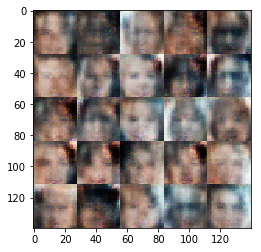

Epoch 1/1... Discriminator Loss: 0.3363... Generator Loss: 3.5686
Epoch 1/1... Discriminator Loss: 0.3232... Generator Loss: 3.5537
Epoch 1/1... Discriminator Loss: 0.9076... Generator Loss: 0.7153
Epoch 1/1... Discriminator Loss: 0.3924... Generator Loss: 3.3877
Epoch 1/1... Discriminator Loss: 0.4132... Generator Loss: 2.1009
Epoch 1/1... Discriminator Loss: 0.3656... Generator Loss: 3.6318
Epoch 1/1... Discriminator Loss: 0.2333... Generator Loss: 3.1146
Epoch 1/1... Discriminator Loss: 0.5772... Generator Loss: 3.7486
Epoch 1/1... Discriminator Loss: 0.3710... Generator Loss: 2.0642
Epoch 1/1... Discriminator Loss: 0.4028... Generator Loss: 3.2371


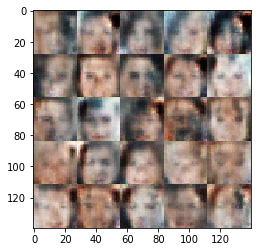

Epoch 1/1... Discriminator Loss: 0.2694... Generator Loss: 2.6246
Epoch 1/1... Discriminator Loss: 0.3444... Generator Loss: 2.3898
Epoch 1/1... Discriminator Loss: 0.2852... Generator Loss: 2.5061
Epoch 1/1... Discriminator Loss: 0.3735... Generator Loss: 4.9070
Epoch 1/1... Discriminator Loss: 0.2136... Generator Loss: 3.5716
Epoch 1/1... Discriminator Loss: 0.5291... Generator Loss: 1.3376
Epoch 1/1... Discriminator Loss: 1.0595... Generator Loss: 0.5471
Epoch 1/1... Discriminator Loss: 0.6665... Generator Loss: 3.5276
Epoch 1/1... Discriminator Loss: 0.3207... Generator Loss: 2.2200
Epoch 1/1... Discriminator Loss: 0.2850... Generator Loss: 4.3743


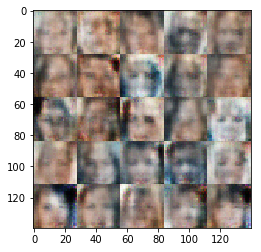

Epoch 1/1... Discriminator Loss: 0.2798... Generator Loss: 4.1343
Epoch 1/1... Discriminator Loss: 0.2738... Generator Loss: 3.8998
Epoch 1/1... Discriminator Loss: 0.5142... Generator Loss: 1.3879
Epoch 1/1... Discriminator Loss: 1.4577... Generator Loss: 0.3908
Epoch 1/1... Discriminator Loss: 1.2791... Generator Loss: 4.4326
Epoch 1/1... Discriminator Loss: 1.4398... Generator Loss: 0.4107
Epoch 1/1... Discriminator Loss: 0.4632... Generator Loss: 1.9355
Epoch 1/1... Discriminator Loss: 1.4470... Generator Loss: 0.4165
Epoch 1/1... Discriminator Loss: 0.9029... Generator Loss: 5.1121
Epoch 1/1... Discriminator Loss: 0.3800... Generator Loss: 2.7347


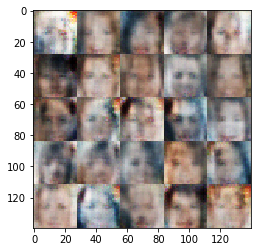

Epoch 1/1... Discriminator Loss: 0.7980... Generator Loss: 2.7075
Epoch 1/1... Discriminator Loss: 1.1145... Generator Loss: 0.6373
Epoch 1/1... Discriminator Loss: 0.4264... Generator Loss: 1.9382
Epoch 1/1... Discriminator Loss: 0.4041... Generator Loss: 2.5785
Epoch 1/1... Discriminator Loss: 0.3162... Generator Loss: 4.7107
Epoch 1/1... Discriminator Loss: 0.5344... Generator Loss: 3.1226
Epoch 1/1... Discriminator Loss: 0.4509... Generator Loss: 1.6608
Epoch 1/1... Discriminator Loss: 1.1703... Generator Loss: 0.6094
Epoch 1/1... Discriminator Loss: 0.3041... Generator Loss: 3.0861
Epoch 1/1... Discriminator Loss: 0.3001... Generator Loss: 3.2027


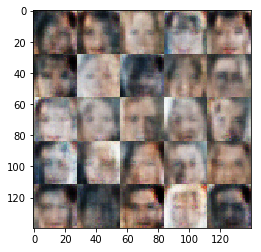

Epoch 1/1... Discriminator Loss: 0.4922... Generator Loss: 4.5326
Epoch 1/1... Discriminator Loss: 0.3209... Generator Loss: 3.7073
Epoch 1/1... Discriminator Loss: 2.0352... Generator Loss: 0.1873
Epoch 1/1... Discriminator Loss: 0.5085... Generator Loss: 2.2616
Epoch 1/1... Discriminator Loss: 0.2874... Generator Loss: 2.1239
Epoch 1/1... Discriminator Loss: 0.6180... Generator Loss: 2.5270
Epoch 1/1... Discriminator Loss: 0.5184... Generator Loss: 1.9881
Epoch 1/1... Discriminator Loss: 0.2349... Generator Loss: 3.2649
Epoch 1/1... Discriminator Loss: 0.3044... Generator Loss: 6.6045
Epoch 1/1... Discriminator Loss: 0.2240... Generator Loss: 4.0775


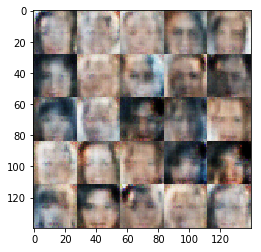

Epoch 1/1... Discriminator Loss: 0.4283... Generator Loss: 2.1319
Epoch 1/1... Discriminator Loss: 0.2218... Generator Loss: 5.6035
Epoch 1/1... Discriminator Loss: 0.3017... Generator Loss: 3.3166
Epoch 1/1... Discriminator Loss: 0.6367... Generator Loss: 1.0969
Epoch 1/1... Discriminator Loss: 1.0133... Generator Loss: 0.9551
Epoch 1/1... Discriminator Loss: 0.1845... Generator Loss: 5.0285
Epoch 1/1... Discriminator Loss: 0.5426... Generator Loss: 4.1170
Epoch 1/1... Discriminator Loss: 0.3317... Generator Loss: 3.5064
Epoch 1/1... Discriminator Loss: 0.5018... Generator Loss: 1.8861
Epoch 1/1... Discriminator Loss: 1.1454... Generator Loss: 0.6206


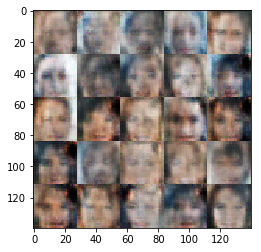

Epoch 1/1... Discriminator Loss: 0.1747... Generator Loss: 4.7344
Epoch 1/1... Discriminator Loss: 0.3249... Generator Loss: 4.3674
Epoch 1/1... Discriminator Loss: 0.1807... Generator Loss: 4.0311
Epoch 1/1... Discriminator Loss: 0.4567... Generator Loss: 1.7165
Epoch 1/1... Discriminator Loss: 0.9632... Generator Loss: 0.6450
Epoch 1/1... Discriminator Loss: 0.3554... Generator Loss: 4.9322
Epoch 1/1... Discriminator Loss: 0.3191... Generator Loss: 2.6169
Epoch 1/1... Discriminator Loss: 0.9324... Generator Loss: 0.8574


In [14]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.